In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Activation
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import LambdaCallback, ModelCheckpoint
import random
import sys
import io

/Users/mranaivoharison/opt/anaconda3/envs/py37nlp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mranaivoharison/opt/anaconda3/envs/py37nlp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mranaivoharison/opt/anaconda3/envs/py37nlp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [3]:
#print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
filename = "../data/biographie_df.csv"

In [4]:
# Read in only the two columns we need 
chat = pd.read_csv(filename, encoding="utf-8", sep=";", usecols = ['name', 'biographie'])
# chat = pd.read_csv(filename, encoding="utf-8", sep=";")
# We don't want bots :) 
chat.head()

,name,biographie
0,Eminem,"Marshall Bruce Mathers III (born October 17, 1..."
1,Lady Gaga,Stefani Joanne Angelina Germanotta ( STEF-ən-e...
2,Justin Bieber,"Justin Drew Bieber (; born March 1, 1994) is a..."
3,Lil Wayne,"Dwayne Michael Carter Jr. (born September 27, ..."
4,Miley Cyrus,"Miley Ray Hemsworth (née Cyrus, born Destiny H..."


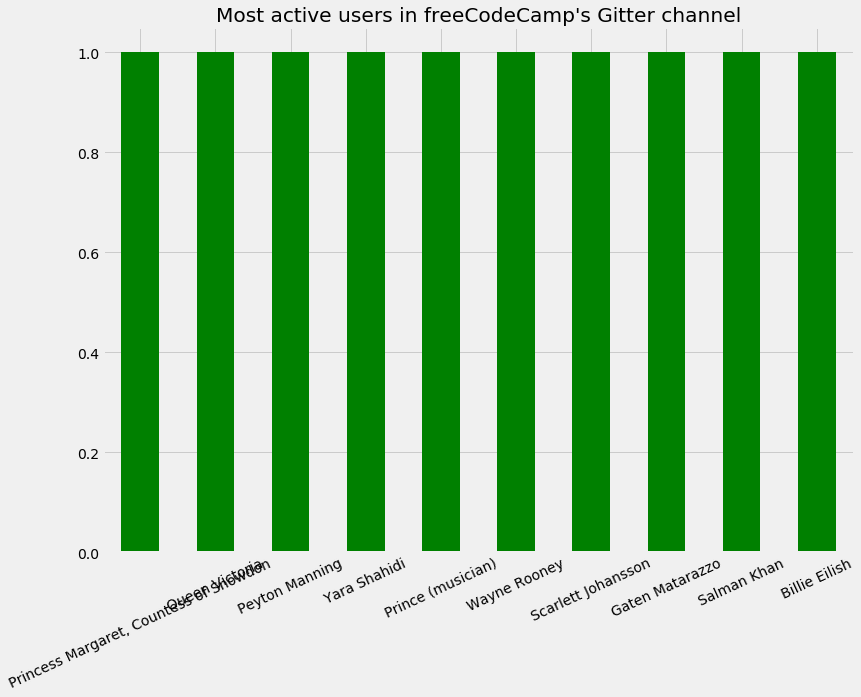

In [5]:
plt.style.use('fivethirtyeight')
f, g = plt.subplots(figsize=(12, 9))
chat['name'].value_counts().head(10).plot.bar(color="green")
g.set_xticklabels(g.get_xticklabels(), rotation=25)
plt.title("Most active users in freeCodeCamp's Gitter channel")
plt.show(g)

In [6]:
chat[chat['name'] == "Justin Bieber"].biographie.head(20)

2    Justin Drew Bieber (; born March 1, 1994) is a...
Name: biographie, dtype: object

In [49]:
user = chat['biographie'][2] # Justin Bieber

n_messages = len(user)
n_chars = len(' '.join(map(str, user)))

print("55a7c9e08a7b72f55c3f991e accounts for %d messages" % n_messages)
print("Their messages add up to %d characters" % n_chars)

55a7c9e08a7b72f55c3f991e accounts for 46691 messages
Their messages add up to 93381 characters


In [50]:
sample_size = int(len(user) * 0.2)

user = user[:sample_size]
user = ''.join(map(str, user)).lower()

user[:100] # Show first 100 characters

'justin drew bieber (; born march 1, 1994) is a canadian singer-songwriter and actor.  encountered at'

In [51]:
chars = sorted(list(set(user)))
print('Count of unique characters (i.e., features):', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Count of unique characters (i.e., features): 54


In [52]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(user) - maxlen, step):
    sentences.append(user[i: i + maxlen])
    next_chars.append(user[i + maxlen])
print('Number of sequences:', len(sentences), "\n")

print(sentences[:10], "\n")
print(next_chars[:10])

Number of sequences: 3100 

['justin drew bieber (; born march 1, 1994', 'tin drew bieber (; born march 1, 1994) i', ' drew bieber (; born march 1, 1994) is a', 'ew bieber (; born march 1, 1994) is a ca', 'bieber (; born march 1, 1994) is a canad', 'ber (; born march 1, 1994) is a canadian', ' (; born march 1, 1994) is a canadian si', ' born march 1, 1994) is a canadian singe', 'rn march 1, 1994) is a canadian singer-s', 'march 1, 1994) is a canadian singer-song'] 

[')', 's', ' ', 'n', 'i', ' ', 'n', 'r', 'o', 'w']


In [53]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [54]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [55]:
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [57]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [58]:
def on_epoch_end(epoch, logs):
    # Function invoked for specified epochs. Prints generated text.
    # Using epoch+1 to be consistent with the training epochs printed by Keras
    if epoch+1 == 1 or epoch+1 == 15:
        print()
        print('----- Generating text after Epoch: %d' % epoch)

        start_index = random.randint(0, len(user) - maxlen - 1)
        for diversity in [0.2, 0.5, 1.0, 1.2]:
            print('----- diversity:', diversity)

            generated = ''
            sentence = user[start_index: start_index + maxlen]
            generated += sentence
            print('----- Generating with seed: "' + sentence + '"')
            sys.stdout.write(generated)

            for i in range(400):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

                sys.stdout.write(next_char)
                sys.stdout.flush()
            print()
    else:
        print()
        print('----- Not generating text after Epoch: %d' % epoch)

In [59]:
generate_text = LambdaCallback(on_epoch_end=on_epoch_end)

# Training the model and generating predictions

In [60]:
# define the checkpoint
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# fit model using our gpu
with tf.device('/gpu:0'):
    model.fit(x, y,
              batch_size=128,
              epochs=15,
              verbose=2,
              callbacks=[generate_text, checkpoint])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/15

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: " of bieber's 2007 youtube videos by acci"
 of bieber's 2007 youtube videos by accieeeteteeett teeette eteateteteeeeeetttteee te eeeeeeeee  teeeeeteteeeeaeete e tte eetaeteteeete eteeeeetteeeeeteeeeeee eeeeeeeee teteeetee eeee eee eeeetetteeeee etteeeteeet eeeeeteeeeteateeeeeeeeeteeeteteeeeteeeeeeeeeeeeae eeeee ttt  eateeeeteeateteteteteeteeettertetea eeeeeeeee eletee e eettee teeeeteae ee teeteeettteeeeteeeeeeteeeeeteeeeeteeteeeetetatetteetewteete te eeae aeetete eteee eeeteeea
----- diversity: 0.5
----- Generating with seed: " of bieber's 2007 youtube videos by acci"
 of bieber's 2007 youtube videos by accitiasea af  et2 t eeoret aotmmaereh tjateteettl a m  ttmsee setteeatr peet 0eeei teeeneewate bem sefbe atebeg ala  atereo bettteeinesbtteetaaoolalath at tetywieele ppeteehi ifpalw  teeegewhieos